In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import percentileofscore
import random
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew, kurtosis
from scipy import stats

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec, starting_h_day, FB_process
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [59]:
path_extracted_data = config.path_extracted_data

# download data

In [4]:
#initial data
df_init = pd.read_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'),sep=',')
print(df_init.shape)
display(df_init.head(3))

(2228, 22)


,HAID,HenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,...,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,chi2distance,severity,gap,weight
0,created,EXP2_hen_1,1,0.00,148,0,Exp2,1,0,1,...,3.731609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HA1,EXP2_hen_1,1,0.85,174,0,Exp2,1,0,1,...,4.000000,170.0,56.738022,14.293588,3.680272,5.312341,0.247844,0.0,0.0,1691.7
2,HA2,EXP2_hen_1,1,3.16,244,0,Exp2,1,0,1,...,4.000000,240.0,65.240079,11.952381,5.030612,4.624683,0.294651,0.0,0.0,1722.2


In [85]:
#model check
#chose Y2 
dico_Y_name = {'proptime_5_Zone':'DurZ5','chi2distance':'Chi2','VTDperhour':'VTD'}
Y2 = 'VTDperhour'
name = dico_Y_name[Y2]+'_severity_trend_allti_rs0'
path_save = os.path.join(path_extracted_data,'LongformatModels',name)
df_check = pd.read_csv(os.path.join(path_save,name+'df_res_yprior.csv'),sep=',', index_col=0)
print(df_check.shape)
display(df_check.head(3))

C:\Users\camil\AppData\Local\Temp/ipykernel_18044/3119292937.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv(os.path.join(path_save,name+'df_res_yprior.csv'),sep=',', index_col=0)


(9447444, 11)


,Obs,Row,V1,variable,value,Element,Time,Subject,Sample,Col,sd
1,1,Y1,1.0,value,NaN,y,0.000000,1,NaN,NaN,NaN
2,1,Y2,1.0,value,NaN,y,0.000000,1,NaN,NaN,NaN
3,2,Y1,1.0,value,NaN,y,0.059319,1,NaN,NaN,NaN


# residual check

### check datastructure

In [87]:
df_check['Element'].value_counts()

etaupdcov       2222928
etasmoothcov    2222928
etapriorcov     2222928
etaprior         370488
etasmooth        370488
etaupd           370488
ypriorcov        246992
yupdcov          246992
ysmoothcov       246992
errupd           123496
errprior         123496
y                123496
ysmooth          123496
yupd             123496
yprior           123496
errsmooth        123496
llrow             61748
Name: Element, dtype: int64

In [88]:
df_check.groupby('Element')[['Row','Col']].value_counts().reset_index()

,Element,Row,Col,0
0,etaprior,KBF,KBF,61748
1,etaprior,VTD,VTD,61748
2,etaprior,cintKBF,cintKBF,61748
3,etaprior,cintVTD,cintVTD,61748
4,etaprior,dynKBF,dynKBF,61748
...,...,...,...,...
139,yupd,Y2,Y2,61748
140,yupdcov,Y1,Y1,61748
141,yupdcov,Y1,Y2,61748
142,yupdcov,Y2,Y1,61748


In [139]:
df_check['Col'] = df_check['Col'].map(lambda x: str(x))
df_check['element_Row_Col'] = df_check.apply(lambda x: x['Element']+'_'+x['Row']+'_'+x['Col'] if x['Element'] in ['etaprior','y','yprior','ysmooth'] else '', axis=1)
df_check

,Obs,Row,V1,variable,value,Element,Time,Subject,Sample,Col,sd,element_Row_Col
1,1,Y1,1.0,value,NaN,y,0.000000,1,NaN,nan,NaN,y_Y1_nan
2,1,Y2,1.0,value,NaN,y,0.000000,1,NaN,nan,NaN,y_Y2_nan
3,2,Y1,1.0,value,NaN,y,0.059319,1,NaN,nan,NaN,y_Y1_nan
4,2,Y2,1.0,value,NaN,y,0.059319,1,NaN,nan,NaN,y_Y2_nan
5,3,Y1,1.0,value,NaN,y,0.118638,1,NaN,nan,NaN,y_Y1_nan
...,...,...,...,...,...,...,...,...,...,...,...,...
9447440,61746,Y2,NaN,value,NaN,errsmooth,9.372417,372,1.0,nan,NaN,
9447441,61747,Y1,NaN,value,NaN,errsmooth,9.431736,372,1.0,nan,NaN,
9447442,61747,Y2,NaN,value,NaN,errsmooth,9.431736,372,1.0,nan,NaN,
9447443,61748,Y1,NaN,value,NaN,errsmooth,9.491055,372,1.0,nan,NaN,


In [140]:
df_check['element_Row_Col'] = df_check['element_Row_Col'].map(lambda x: x.split('_nan')[0])

In [142]:
df_ = df_check[df_check['Element'].isin(['etaprior','yprior','y','ysmooth'])].groupby('Element')[['Row','Col','element_Row_Col']].value_counts(dropna=False).reset_index()
display(df_)
li_keep = df_['element_Row_Col'].tolist()

,Element,Row,Col,element_Row_Col,0
0,etaprior,KBF,KBF,etaprior_KBF_KBF,61748
1,etaprior,VTD,VTD,etaprior_VTD_VTD,61748
2,etaprior,cintKBF,cintKBF,etaprior_cintKBF_cintKBF,61748
3,etaprior,cintVTD,cintVTD,etaprior_cintVTD_cintVTD,61748
4,etaprior,dynKBF,dynKBF,etaprior_dynKBF_dynKBF,61748
5,etaprior,dynVTD,dynVTD,etaprior_dynVTD_dynVTD,61748
6,y,Y1,nan,y_Y1,61748
7,y,Y2,nan,y_Y2,61748
8,yprior,Y1,Y1,yprior_Y1_Y1,61748
9,yprior,Y2,Y2,yprior_Y2_Y2,61748


In [143]:
#keep only what we want
df_residuals = df_check[df_check['element_Row_Col'].isin(li_keep)].copy()
print(df_residuals.shape)
display(df_residuals.head(2))

#reshape it to have same nbr of rows as initial data and columns with the manifests residuals and smoot, latente prediction as well
df_residuals = df_residuals.pivot(index=['Time','Subject'], columns='element_Row_Col', values='value').reset_index()
print(df_residuals.shape)
df_residuals = df_residuals[~df_residuals['y_Y1'].isnull()]
#observed-predicted
df_residuals['manifest_residualsY1'] = df_residuals['y_Y1']-df_residuals['yprior_Y1_Y1']
df_residuals['manifest_residualsY2'] = df_residuals['y_Y2']-df_residuals['yprior_Y2_Y2']
#display(df_['Time'].value_counts())
print(df_residuals.shape)
display(df_residuals.head(3))

(740976, 12)


,Obs,Row,V1,variable,value,Element,Time,Subject,Sample,Col,sd,element_Row_Col
1,1,Y1,1.0,value,NaN,y,0.0,1,NaN,nan,NaN,y_Y1
2,1,Y2,1.0,value,NaN,y,0.0,1,NaN,nan,NaN,y_Y2


(61748, 14)
(1875, 16)


element_Row_Col,Time,Subject,etaprior_KBF_KBF,etaprior_VTD_VTD,etaprior_cintKBF_cintKBF,etaprior_cintVTD_cintVTD,etaprior_dynKBF_dynKBF,etaprior_dynVTD_dynVTD,y_Y1,y_Y2,yprior_Y1_Y1,yprior_Y2_Y2,ysmooth_Y1_Y1,ysmooth_Y2_Y2,manifest_residualsY1,manifest_residualsY2
312,0.0,313,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,0.449111,-0.262324,-0.708234,-0.002264,-0.220198,-0.309546,1.157346,-0.260060
313,0.0,314,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,-0.931354,1.169990,-0.708234,-0.002264,-0.930088,0.769966,-0.223120,1.172254
314,0.0,315,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,-0.931354,-0.209709,-0.708234,-0.002264,-0.951062,0.363500,-0.223120,-0.207445


In [144]:
#add original covariates
df_residuals = pd.merge(df_residuals, df_init[~df_init['severity'].isnull()], 
                    left_on=['Subject','Time'], 
                    right_on=['id','MonthInstudy'], 
                    how='outer')
print(df_residuals.shape)
display(df_residuals.head(2))

(1875, 38)


,Time,Subject,etaprior_KBF_KBF,etaprior_VTD_VTD,etaprior_cintKBF_cintKBF,etaprior_cintVTD_cintVTD,etaprior_dynKBF_dynKBF,etaprior_dynVTD_dynVTD,y_Y1,y_Y2,...,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,chi2distance,severity,gap,weight
0,0.0,313,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,0.449111,-0.262324,...,3.5,144.5,14.769965,0.014468,3.375000,NaN,0.234178,35.0,1.0,NaN
1,0.0,314,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,-0.931354,1.169990,...,3.5,144.5,4.859375,6.604167,5.927083,NaN,0.246244,0.0,0.0,NaN


df_residuals = df_check[df_check['Element'].isin(['yprior','y'])].copy()
print(df_residuals.shape)
display(df_residuals.head(2))

df_residuals = df_residuals.pivot(index=['Time','Subject','Row'], columns='Element', values='value').reset_index()
print(df_residuals.shape)
df_residuals = df_residuals[~df_residuals['y'].isnull()]
print(df_residuals.shape)
#observed-predicted
df_residuals['manifest_residuals'] = df_residuals['y']-df_residuals['yprior']
#display(df_['Time'].value_counts())
display(df_residuals.head(3))
#reshape
df_residuals = df_residuals.pivot(index=['Time','Subject'], columns='Row', values=['y','yprior','manifest_residuals']).reset_index()
display(df_residuals.head(3))
df_residuals.columns = [' '.join([str(i) for i in col]).strip() for col in df_residuals.columns.values]
#small check its of the expected shape
if df_residuals.shape[0]!=df_init[~df_init['severity'].isnull()].shape[0]:
    print('NOT OF EXPECTED SHAPE')
print(df_residuals.shape)
display(df_residuals.head(3))

#add original covariates
df_residuals = pd.merge(df_residuals, df_init[~df_init['severity'].isnull()], 
                    left_on=['Subject','Time'], 
                    right_on=['id','MonthInstudy'], 
                    how='outer')
print(df_residuals.shape)
display(df_residuals.head(2))

In [145]:
####### checks
#small check its of the expected shape
if df_residuals.shape[0]!=df_init[~df_init['severity'].isnull()].shape[0]:
    print('NOT OF EXPECTED SHAPE')
print(df_residuals.shape)
display(df_residuals.head(3))

# check y is the observed data and so if the data are correctly merged... yes :)
df_residuals['VTDperhour_SC'] = stats.zscore(df_residuals['VTDperhour'])
df_residuals['proptime_5_Zone_SC'] = stats.zscore(df_residuals['proptime_5_Zone'])
df_residuals['chi2distance_SC'] = stats.zscore(df_residuals['chi2distance'])
df_residuals['severity_SC'] = stats.zscore(df_residuals['severity'])

# check y is the observed data and so if the data are correctly merged... yes :)
df_residuals[Y2+'_SC'] = stats.zscore(df_residuals[Y2])
df_residuals['severity_SC'] = stats.zscore(df_residuals['severity'])
df_residuals[['y_Y1', 'severity_SC', 'severity','y_Y2', Y2+'_SC', Y2]]

(1875, 38)


,Time,Subject,etaprior_KBF_KBF,etaprior_VTD_VTD,etaprior_cintKBF_cintKBF,etaprior_cintVTD_cintVTD,etaprior_dynKBF_dynKBF,etaprior_dynVTD_dynVTD,y_Y1,y_Y2,...,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,chi2distance,severity,gap,weight
0,0.0,313,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,0.449111,-0.262324,...,3.5,144.5,14.769965,0.014468,3.375000,NaN,0.234178,35.0,1.0,NaN
1,0.0,314,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,-0.931354,1.169990,...,3.5,144.5,4.859375,6.604167,5.927083,NaN,0.246244,0.0,0.0,NaN
2,0.0,315,-0.546062,2.182948,0.236519,-0.092402,-0.104463,-2.127442,-0.931354,-0.209709,...,3.5,144.5,3.889178,0.000000,3.468750,NaN,0.470640,0.0,0.0,NaN


,y_Y1,severity_SC,severity,y_Y2,VTDperhour_SC,VTDperhour
0,0.449111,0.449231,35.0,-0.262324,-0.262394,3.375000
1,-0.931354,-0.931602,0.0,1.169990,1.170302,5.927083
2,-0.931354,-0.931602,0.0,-0.209709,-0.209765,3.468750
3,-0.931354,-0.931602,0.0,-0.969712,-0.969971,2.114583
4,-0.931354,-0.931602,0.0,-0.928789,-0.929037,2.187500
...,...,...,...,...,...,...
1870,1.435158,1.435541,60.0,-0.291555,-0.291633,3.322917
1871,2.263437,2.264041,81.0,-0.648172,-0.648345,2.687500
1872,2.184554,2.185136,79.0,-1.861840,-1.862337,0.525000
1873,2.302879,2.303494,82.0,-1.361407,-1.361770,1.416667


# residual check

In [147]:
df_residuals.columns

Index(['Time', 'Subject', 'etaprior_KBF_KBF', 'etaprior_VTD_VTD',
       'etaprior_cintKBF_cintKBF', 'etaprior_cintVTD_cintVTD',
       'etaprior_dynKBF_dynKBF', 'etaprior_dynVTD_dynVTD', 'y_Y1', 'y_Y2',
       'yprior_Y1_Y1', 'yprior_Y2_Y2', 'ysmooth_Y1_Y1', 'ysmooth_Y2_Y2',
       'manifest_residualsY1', 'manifest_residualsY2', 'HAID', 'HenID', 'id',
       'MonthInstudy', 'DOAHA', 'IsOFH', 'ExperimentID', 'Is_relocated',
       'Is_exp1', 'Is_exp2', 'Is_exp3', 'early_death', 'time2event', 'DOA',
       'proptime_2_Zone', 'proptime_5_Zone', 'VTDperhour',
       'mid_cum_Z4_h_Morning', 'chi2distance', 'severity', 'gap', 'weight',
       'VTDperhour_SC', 'proptime_5_Zone_SC', 'chi2distance_SC',
       'severity_SC'],
      dtype='object')

In [148]:
li_res = ['manifest_residualsY1','manifest_residualsY2']
li_catcov = ['IsOFH','ExperimentID','Is_relocated']
li_contcov = ['time2event','MonthInstudy','severity','weight','ysmooth_Y1_Y1', 'ysmooth_Y2_Y2']+[Y2]+[i for i in df_residuals.columns if i.startswith('etaprior')]
li_contcov

['time2event',
 'MonthInstudy',
 'severity',
 'weight',
 'ysmooth_Y1_Y1',
 'ysmooth_Y2_Y2',
 'VTDperhour',
 'etaprior_KBF_KBF',
 'etaprior_VTD_VTD',
 'etaprior_cintKBF_cintKBF',
 'etaprior_cintVTD_cintVTD',
 'etaprior_dynKBF_dynKBF',
 'etaprior_dynVTD_dynVTD']

### overall - manifest & latent residuals

manifest_residualsY1 kurtosis: 4.81
manifest_residualsY1 skew: 1.63


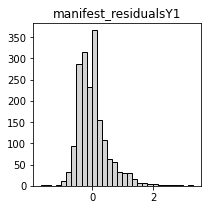

manifest_residualsY2 kurtosis: 3.40
manifest_residualsY2 skew: 0.69


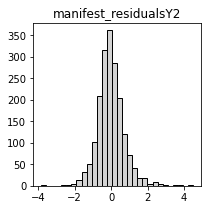

In [149]:
#Skewness is a measure of the lack of symmetry. 
#Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
#"Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if skewness is between ‐2 to +2 and kurtosis 
#is between ‐7 to +7.""
for t in li_res:
    plt.figure(figsize=(3,3))
    li = df_residuals[t]
    plt.hist(li, color='lightgrey', edgecolor = "black", bins=30);
    plt.title(t)
    print(t+' kurtosis: %.2f'%kurtosis(li))
    print(t+' skew: %.2f'%skew(li))
    plt.savefig(os.path.join(path_save,'Residuals_'+t+name+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

### for each categorical covariates

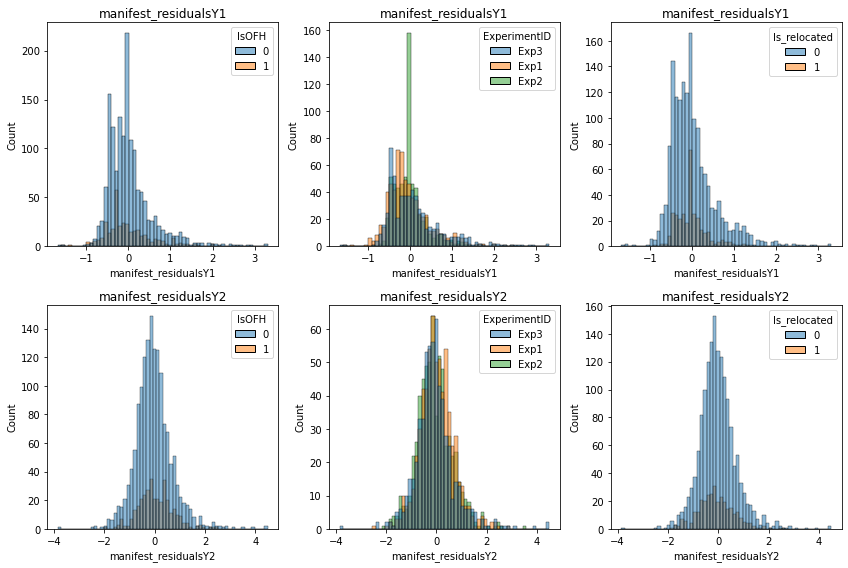

In [150]:
c = len(li_catcov) ; l = len(li_res)
img_w = 4 ; img_h = 4
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for t in li_res:
    for cov in li_catcov:
        plt.subplot(l,c,i)
        plt.tight_layout()
        sns.histplot(data=df_residuals, x=t, hue=cov, fill=True)
        plt.title(t)
        i = i+1
plt.savefig(os.path.join(path_save,'Residuals_categoricalvar'+name+'.png'),dpi=300,format='png',bbox_inches='tight')

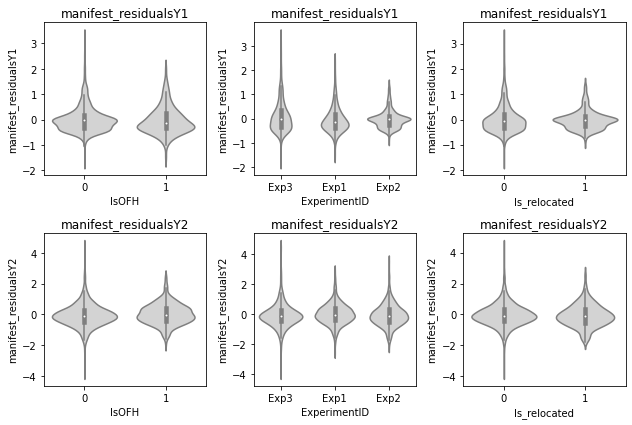

In [152]:
c = len(li_catcov) ; l = len(li_res)
img_w = 3 ; img_h = 3
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for t in li_res:
    for cov in li_catcov:
        plt.subplot(l,c,i)
        plt.tight_layout()
        sns.violinplot(data=df_residuals, y=t, x=cov, color='lightgrey')
        plt.title(t)
        i = i+1
plt.savefig(os.path.join(path_save,'Residuals_categoricalvarviolinplot'+t+name+'.png'),dpi=300,format='png',bbox_inches='tight')

### across continuous covariates

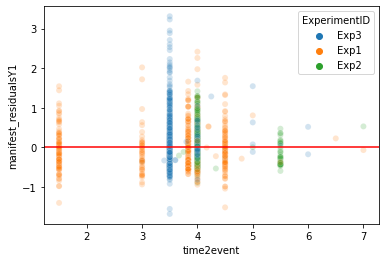

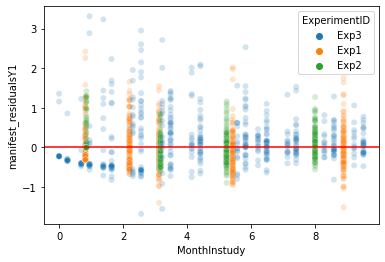

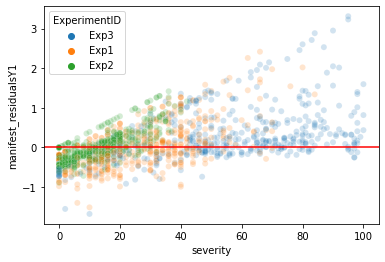

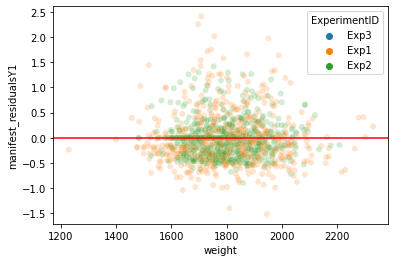

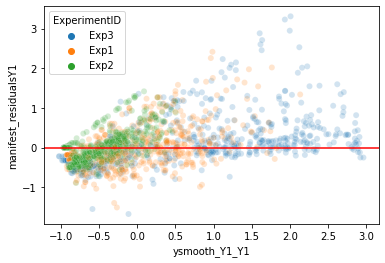

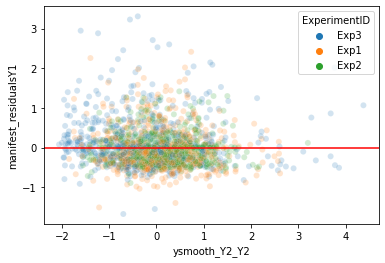

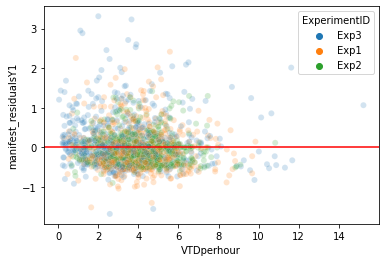

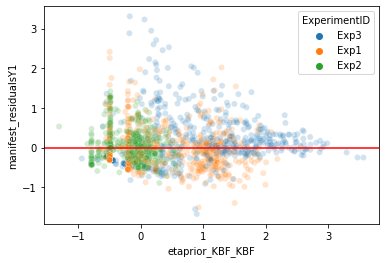

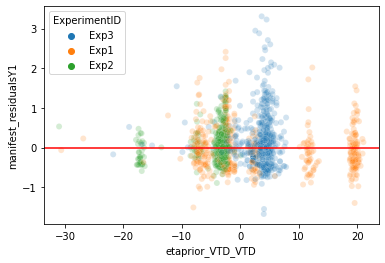

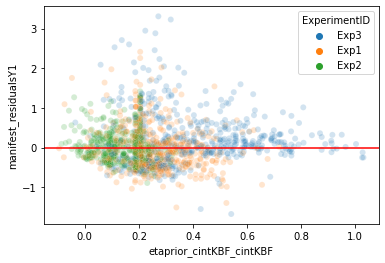

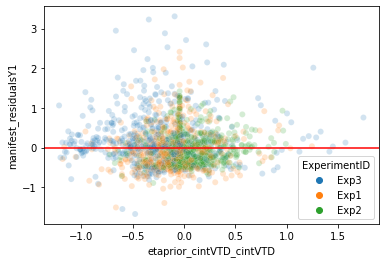

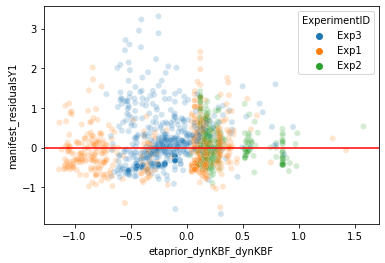

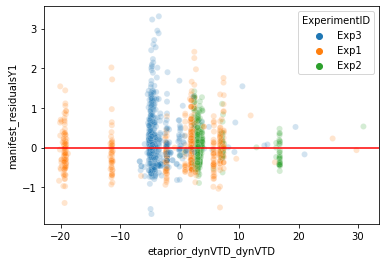

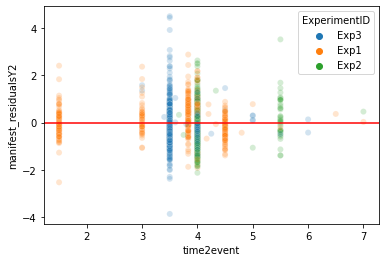

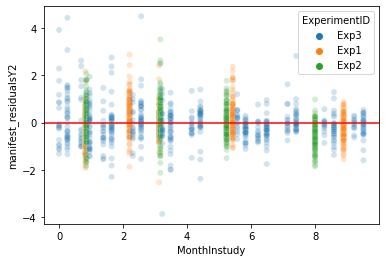

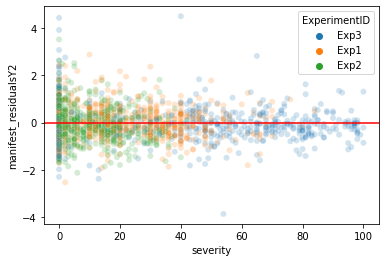

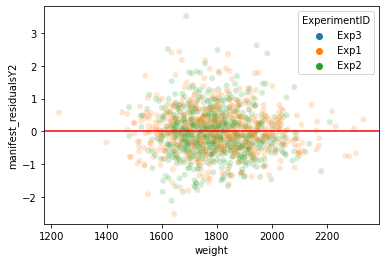

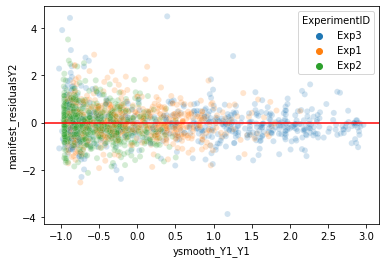

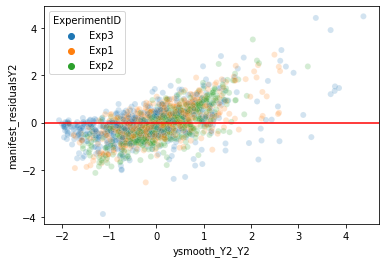

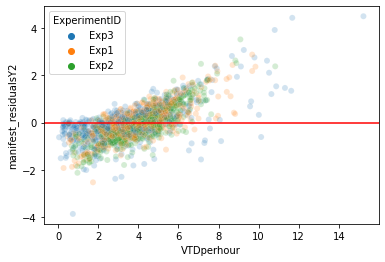

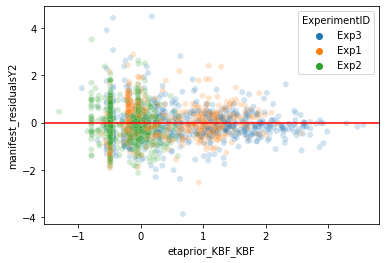

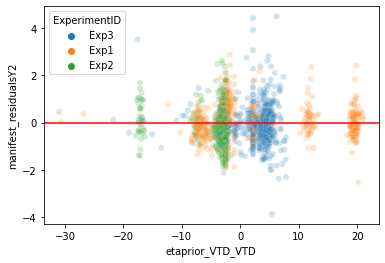

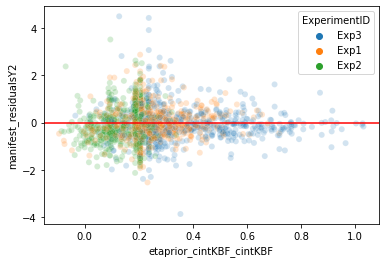

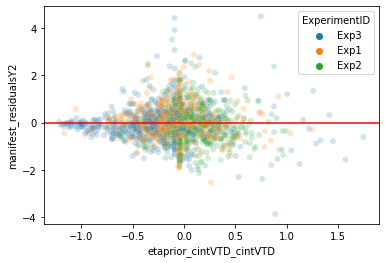

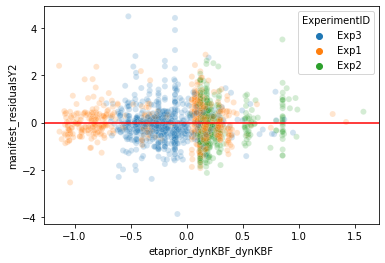

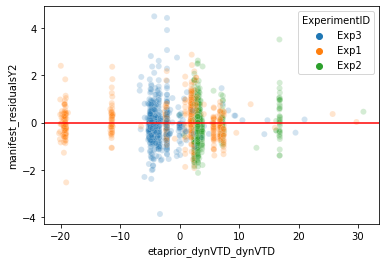

In [153]:
for t in li_res:
    for cov in li_contcov:
        sns.scatterplot(x=cov, y=t, data=df_residuals, hue='ExperimentID', alpha=0.2);
        plt.axhline(y=0, color='red');
        plt.savefig(os.path.join(path_save,'Residuals_categoricalvar'+t+'_'+cov+'_'+name+'.png'),dpi=300,format='png',
                    bbox_inches='tight')
        plt.show();
#VTD: more negative at the end, predicted higher KBF compared to real

### individually

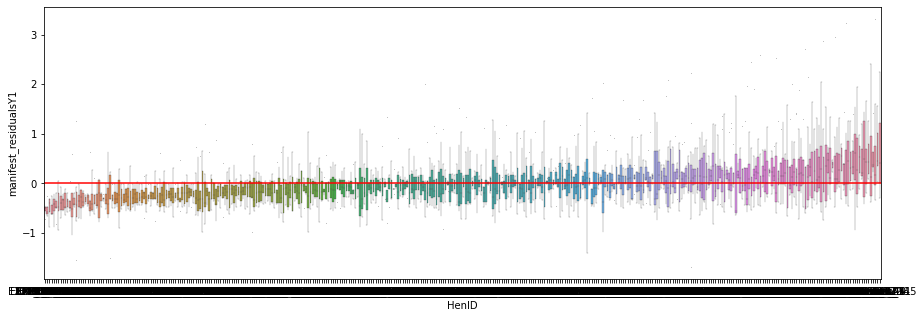

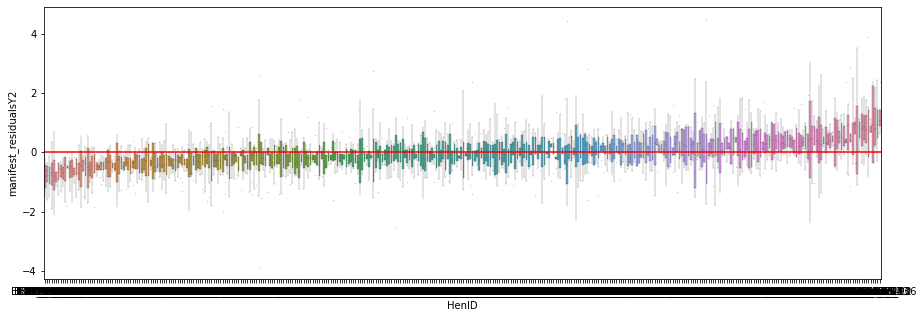

In [178]:
for r in li_res:
    dico_hen_resmean = dict(df_residuals.groupby(['HenID'])[r].mean())
    df_residuals['sortby'] = df_residuals['HenID'].map(lambda x: dico_hen_resmean[x])
    plt.figure(figsize=(15,5))
    df_plt = df_residuals.sort_values('sortby').copy()
    sns.boxplot(data=df_plt, x='HenID',y=r, fliersize=0.1, linewidth=0.3);        
    plt.axhline(y=0, color='red');
    plt.savefig(os.path.join(path_save,'Residuals_Inidvidual_'+r+'.png'),dpi=300,format='png',
                    bbox_inches='tight')
    #we see that for individuals with larger manifestKBF residuals that it is also more variable
    #individual heterogeneity of variance? for KBF not mvt

li_type = ['kurtosis','skew','sd','mean']
c = len(li_type) ; l = len(li_res)
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v in li_res:
    df_ = df_check[(df_check['Element']==v)].groupby(['Subject','ExperimentID'])['value'].agg(lambda x: list(x)).reset_index()
    df_['kurtosis'] = df_['value'].map(lambda x: kurtosis(x))
    df_['skew'] = df_['value'].map(lambda x: skew(x))
    df_['sd'] = df_['value'].map(lambda x: np.std(x))
    df_['mean'] = df_['value'].map(lambda x: np.mean(x))
    print(df_.shape)
    display(df_.head(2))    
    for t in li_type:
        plt.subplot(l,c,i)
        plt.tight_layout()
        sns.histplot(data=df_, x=t, hue='ExperimentID', fill=True); 
        i = i+1
#plt.savefig(os.path.join(path_save,name+'TICovdifference.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

# download the data

In [13]:
#daily var
#eta1=latent process of well-being; eta2=latent process of frequency/duration of use
df = pd.read_csv(os.path.join(path_save,name+'HenIDParameters.csv'), index_col=0, sep=',')
li_indestimate = [i for i in df.columns if i!='id']
print(df.shape)
#add hen info
df_hen = df_init[['id','HenID','ExperimentID','Is_relocated','IsOFH','early_death']].drop_duplicates()
print(df_hen.shape)
df_hen.head(3)
df = pd.merge(df, df_hen, on=['id'], how='left')
df.head(3)

(334, 15)
(334, 6)


,drift_dynKBF,drift_dynKBF_dynVTD,drift_dynVTD,drift_dynVTD_dynKBF,drift_KBF,drift_VTD,mm_Y1,mm_Y2,mvarY1,mvarY2,T0m_cintKBF,T0m_cintVTD,T0m_KBF,T0m_VTD,id,HenID,ExperimentID,Is_relocated,IsOFH,early_death
0,-0.130240,-0.282336,-0.272780,0.112304,-0.427050,-0.040215,3.046796,3.382612,0.440481,0.556663,-1.559623,-0.222859,-4.019168,-2.785857,1,EXP2_hen_1,Exp2,1,0,0.0
1,-0.130721,-0.286685,-0.077758,0.126251,-0.418834,-0.038456,3.042038,3.404769,0.444549,0.611760,-1.414343,-0.200018,-4.106888,-2.442259,2,EXP2_hen_10,Exp2,1,0,0.0
2,-0.129530,-0.251412,-0.018685,0.110248,-0.481049,-0.033974,3.204710,3.791477,0.312825,0.722830,-1.822963,-0.245653,-3.955779,-2.478304,3,EXP2_hen_100,Exp2,1,0,0.0


In [115]:
df_result = pd.read_csv(os.path.join(path_save,name+'ctStanDiscretePars.csv'), sep=',', index_col=0)
df_result = df_result.transpose()
df_result['var'] = df_result.index
print(set([x.split('.')[0] for x in df_result['var'].tolist()]))
print(set([x.split('.')[-1] for x in df_result['var'].tolist()]))
print(set([x.split('.')[-2] for x in df_result['var'].tolist()]))
df_result['timetoshock'] = df_result['var'].map(lambda x: re.findall(r"[-+]?(?:\d*\.*\d+)", x.replace('popmean.',''))[0])
df_result['var2'] = df_result['var'].map(lambda x: x.split('.')[-1])
df_result['var1'] = df_result['var'].map(lambda x: x.split('.')[-2])
df_result['varComb'] = df_result['var'].map(lambda x: x.split('.')[-2]+'_'+x.split('.')[-1])
display(df_result['varComb'].value_counts())
display(df_result['timetoshock'].value_counts())
display(df_result.head(3))
df_result = pd.melt(df_result, id_vars=['timetoshock','varComb','var1','var2'], value_vars=[i for i in df_result.columns if isinstance(i, int)], value_name = 'value')
print(df_result.shape)
display(df_result.head(3))

{'popmean'}
{'VTD', 'cintKBF', 'dynVTD', 'dynKBF', 'cintVTD', 'KBF'}
{'VTD', 'cintKBF', 'dynVTD', 'dynKBF', 'cintVTD', 'KBF'}


KBF_KBF            101
VTD_KBF            101
cintKBF_cintVTD    101
cintVTD_cintVTD    101
dynKBF_cintVTD     101
dynVTD_cintVTD     101
KBF_dynKBF         101
VTD_dynKBF         101
cintKBF_dynKBF     101
cintVTD_dynKBF     101
dynKBF_dynKBF      101
dynVTD_dynKBF      101
KBF_dynVTD         101
VTD_dynVTD         101
cintKBF_dynVTD     101
cintVTD_dynVTD     101
dynKBF_dynVTD      101
VTD_cintVTD        101
KBF_cintVTD        101
dynVTD_cintKBF     101
cintKBF_VTD        101
cintKBF_KBF        101
cintVTD_KBF        101
dynKBF_KBF         101
dynVTD_KBF         101
KBF_VTD            101
VTD_VTD            101
cintVTD_VTD        101
dynKBF_cintKBF     101
dynKBF_VTD         101
dynVTD_VTD         101
KBF_cintKBF        101
VTD_cintKBF        101
cintKBF_cintKBF    101
cintVTD_cintKBF    101
dynVTD_dynVTD      101
Name: varComb, dtype: int64

0      36
6.4    36
7.4    36
7.3    36
7.2    36
       ..
3.1    36
3      36
2.9    36
2.8    36
10     36
Name: timetoshock, Length: 101, dtype: int64

,524,339,626,711,546,569,663,317,769,564,...,60,797,206,996,140,var,timetoshock,var2,var1,varComb
popmean.0.KBF.KBF,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,popmean.0.KBF.KBF,0,KBF,KBF,KBF_KBF
popmean.0.1.KBF.KBF,0.950285,0.949670,0.953325,0.948685,0.952320,0.947809,0.950093,0.945487,0.950655,0.948573,...,0.948425,0.951326,0.946507,0.944733,0.949041,popmean.0.1.KBF.KBF,0.1,KBF,KBF,KBF_KBF
popmean.0.2.KBF.KBF,0.903041,0.901873,0.908829,0.900003,0.906913,0.898341,0.902677,0.893945,0.903744,0.899790,...,0.899509,0.905021,0.895875,0.892520,0.900679,popmean.0.2.KBF.KBF,0.2,KBF,KBF,KBF_KBF


(363600, 6)


,timetoshock,varComb,var1,var2,variable,value
0,0,KBF_KBF,KBF,KBF,524,1.000000
1,0.1,KBF_KBF,KBF,KBF,524,0.950285
2,0.2,KBF_KBF,KBF,KBF,524,0.903041


#small example
#x = [1, 1, 2, 2, 17]
#[percentileofscore(x, a, 'rank') for a in x] #[30.0, 30.0, 70.0, 70.0, 100.0]
df['mvarY2_perc'] = df['mvarY2'].map(lambda x: percentileofscore(df['mvarY2'].tolist(), x, 'rank'))
#plt.hist(df['mvarY2_perc']);
df['mvarY2_perc'] = df['mvarY2_perc'].map(lambda x: round(x/20,0))
df['mvarY2_perc'].value_counts()
sns.displot(df, x="drift_eta2_eta1", hue="mvarY2_perc", kind="kde", fill=True);

## 0. results

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:337: MatplotlibDeprecationWarning: Support for pa

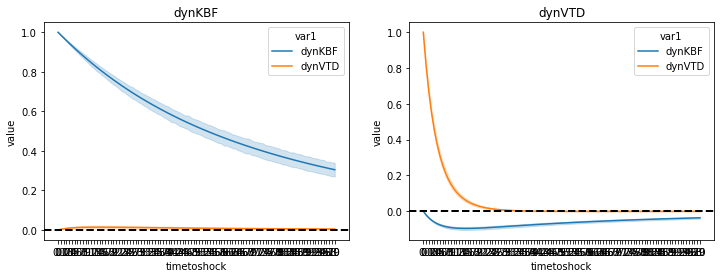

In [116]:
#together
df_plt = df_result[df_result['varComb'].isin(['dynVTD_dynVTD','dynKBF_dynKBF','dynKBF_dynVTD','dynVTD_dynKBF'])].copy()
c = 2 ; l = 1 ; img_w = 6 ; img_h = 4
fig = plt.figure(figsize=(img_w*c, img_h*l))
plt.subplot(l,c,1)
sns.lineplot(x='timetoshock', y='value', hue='var1',data=df_plt[df_plt['var2']=='dynKBF']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynKBF')
plt.subplot(l,c,2)
sns.lineplot(x='timetoshock', y='value', hue='var1',data=df_plt[df_plt['var2']=='dynVTD']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynVTD');

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)


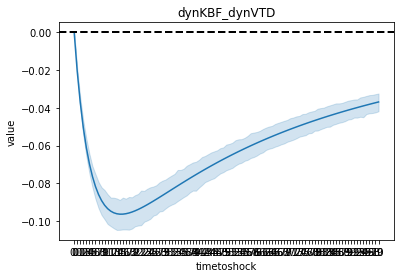

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)


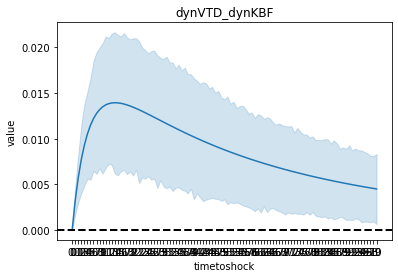

In [117]:
#separately
sns.lineplot(x='timetoshock', y='value', data=df_plt[df_plt['varComb']=='dynKBF_dynVTD']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynKBF_dynVTD')
plt.show()
sns.lineplot(x='timetoshock', y='value', data=df_plt[df_plt['varComb']=='dynVTD_dynKBF']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynVTD_dynKBF');

In [119]:
df[df['id']==323]

,drift_dynKBF,drift_dynKBF_dynVTD,drift_dynVTD,drift_dynVTD_dynKBF,drift_KBF,drift_VTD,mm_Y1,mm_Y2,mvarY1,mvarY2,T0m_cintKBF,T0m_cintVTD,T0m_KBF,T0m_VTD,id,HenID,ExperimentID,Is_relocated,IsOFH,early_death
322,-0.128712,-0.261588,-0.000011,0.034125,-0.366842,-0.042482,3.085212,3.707443,0.506429,0.226563,-0.762263,-0.224753,-3.947299,-3.39172,323,EXP3_hen_109,Exp3,0,0,0.0


In [120]:
df_init[df_init['id']==323]

,HAID,HenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3,early_death,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,severity,gap
1282,HA3B,EXP3_hen_109,323,0.26,198,0,Exp3,0,0,0,1,0.0,3.5,194.5,34.825521,7.522569,4.447917,NaN,0.0,0.0
1283,HA4B,EXP3_hen_109,323,1.18,226,0,Exp3,0,0,0,1,0.0,3.5,222.5,31.965278,26.781250,5.375000,NaN,15.0,1.0
1284,HA5B,EXP3_hen_109,323,2.10,254,0,Exp3,0,0,0,1,0.0,3.5,250.5,2.249711,57.778356,1.395833,NaN,13.0,0.0
1285,HA6B,EXP3_hen_109,323,3.02,282,0,Exp3,0,0,0,1,0.0,3.5,278.5,14.306713,34.759259,3.010417,NaN,10.0,1.0
1286,HA7B,EXP3_hen_109,323,4.44,325,0,Exp3,0,0,0,1,0.0,3.5,321.5,10.131076,60.973090,1.895833,NaN,57.0,1.0
1287,HA8B,EXP3_hen_109,323,5.10,345,0,Exp3,0,0,0,1,0.0,3.5,341.5,11.326389,64.091146,1.354167,NaN,40.0,1.0
1288,HA9B,EXP3_hen_109,323,6.02,373,0,Exp3,0,0,0,1,0.0,3.5,369.5,5.008681,72.646412,1.500000,NaN,80.0,1.0
1289,HA10B,EXP3_hen_109,323,7.20,409,0,Exp3,0,0,0,1,0.0,4.0,405.0,5.708333,81.449653,1.162500,NaN,79.0,1.0
1290,HA11B,EXP3_hen_109,323,8.12,437,0,Exp3,0,0,0,1,0.0,3.5,433.5,3.267940,70.745081,0.562500,NaN,84.0,1.0


## 1. compare with real data

In [57]:
#do scatter plot age kbf age vtd and kbf vtd....
#do tsem with age instead of vtd!

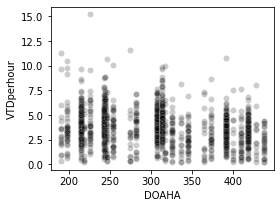

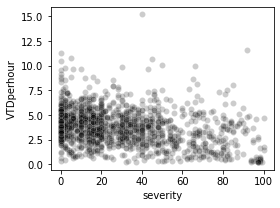

In [58]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='VTDperhour', color='black', data=df_init, alpha=0.2);
plt.figure(figsize=(4,3))
sns.scatterplot(x='severity', y='VTDperhour', color='black', data=df_init, alpha=0.2);
#--> VTDperhour reduce more over severity than DOAHA. I believe the model: the more severe the lesser you move

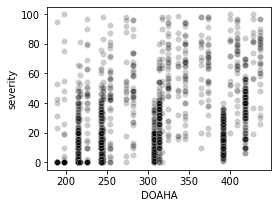

In [59]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='severity', color='black', data=df_init, alpha=0.2);

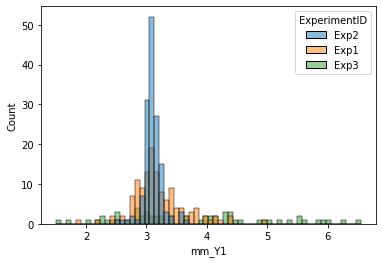

In [60]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

### TICov differ?

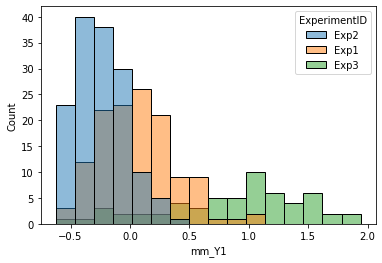

In [11]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

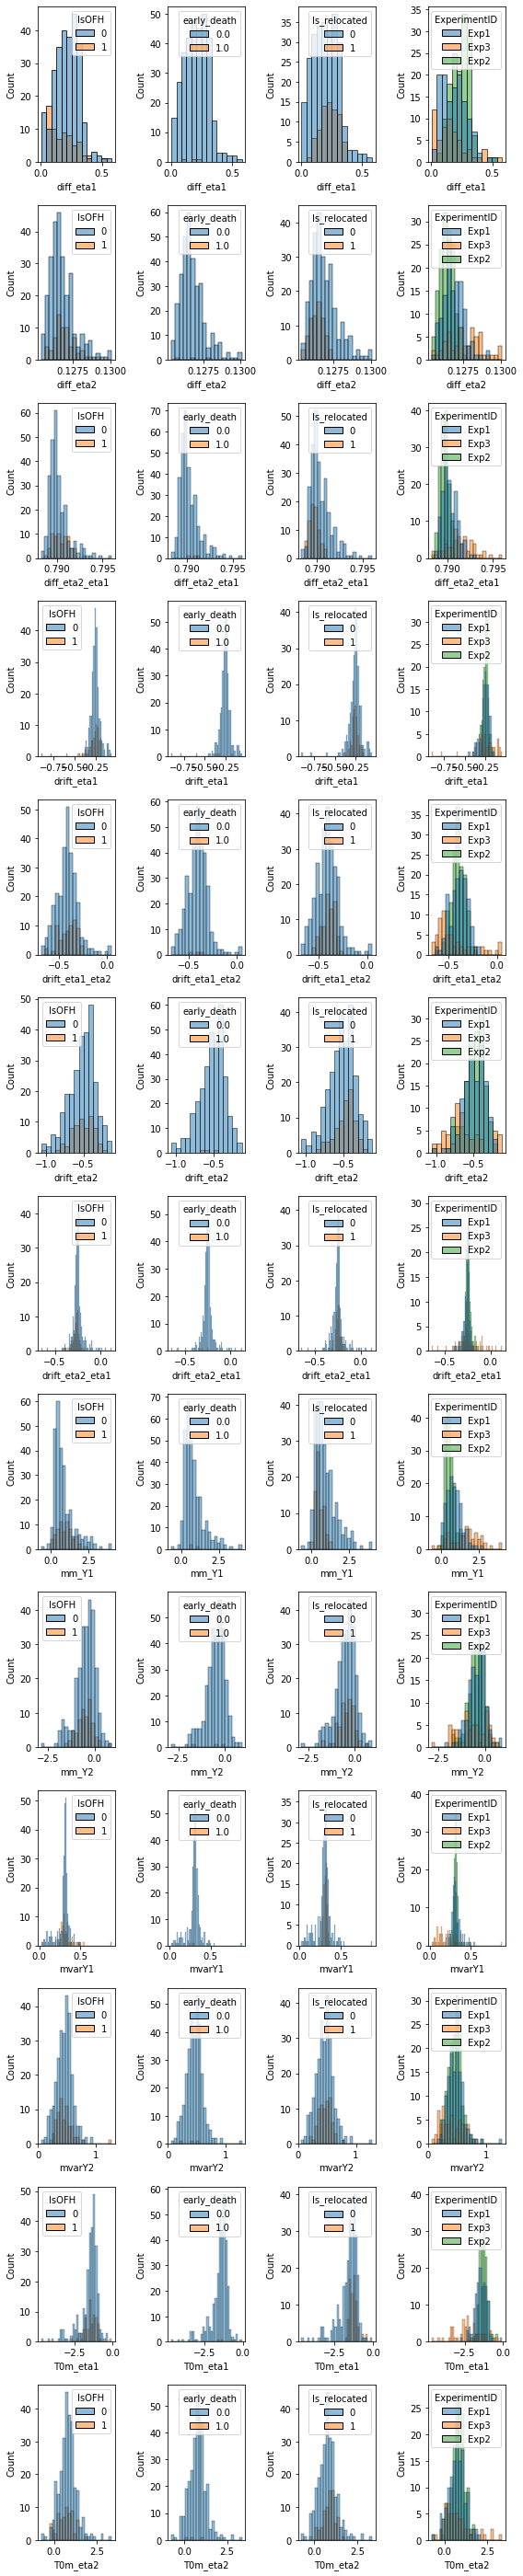

In [7]:
li_cov = ['IsOFH','early_death','Is_relocated','ExperimentID']
c = len(li_cov) ; l = len(li_indestimate)
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v in li_indestimate:
    for h in li_cov:
        plt.subplot(l,c,i)
        plt.tight_layout()
        #plt.figure(figsize=(2,3))
        #plt.grid(True)
        #plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
        #sns.displot(df, x=v, hue=h, kind="kde", fill=True); #does not work, shouldspecify axis
        sns.histplot(df, x=v, hue=h, fill=True); 
        i = i+1
plt.savefig(os.path.join(path_save,name+'TICovdifference.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

### Var in mvt associates with mean in KBF?

SpearmanrResult(correlation=0.969268401478608, pvalue=2.807157095939286e-204)
PearsonRResult(statistic=0.9302453759131697, pvalue=1.3093063211915346e-146)
-------------------------
SpearmanrResult(correlation=-0.13956322932996454, pvalue=0.01066285438832268)
PearsonRResult(statistic=-0.29902125485652775, pvalue=2.51351941617484e-08)
-------------------------
SpearmanrResult(correlation=-0.04857521745536761, pvalue=0.37618960538908186)
PearsonRResult(statistic=-0.24716134883335122, pvalue=4.848909121812093e-06)


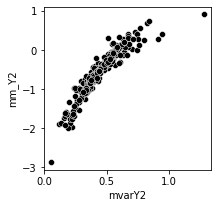

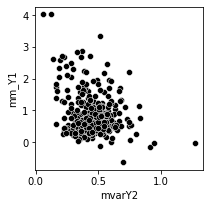

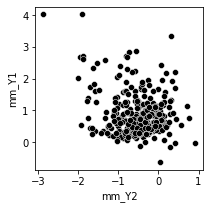

In [8]:
#does hens that have more variation in VTD have lesser intercept of KBF?
#MAYBE: TODO: add all data, and test if mvarY1 or T0var exhibit a different drift
#color='black',hue=df['ExperimentID'].tolist()
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y2', color='black', data=df); #hens that vary a lot have higher mvt
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y2'].tolist())) #stats on stats, but we have the real correlation in the results
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y2'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y1', color='black', data=df); #hens that vary a lot may have lower intercept of KBF
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mm_Y2', y='mm_Y1', color='black',data=df); #hens that have a higher VTD interecept, do not have more or less KBF
print(spearmanr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))

### does hens that have lower VTD have a stronger influence of their mvt on the KBF?

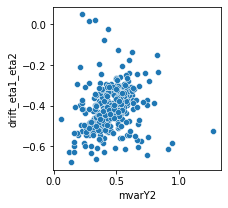

In [9]:
#does hens that have lower VTD have a stronger influence of their mvt on the KBF?
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2',y='drift_eta1_eta2', data=df);
# not so clear

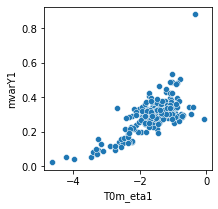

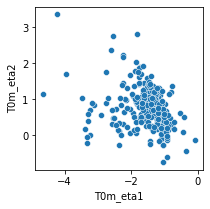

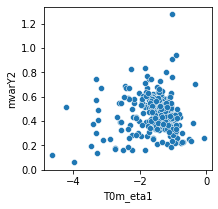

In [10]:
#TODO: THINK ABOUT
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY1', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='T0m_eta2', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY2', data=df);

### mm_- baseline level: ind diff in intercept

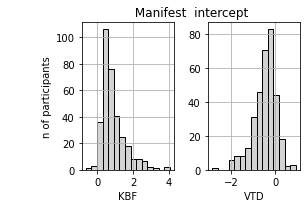

In [20]:
# mm_ : Manifest  means (mm) show the continuous manifest intercept, reflecting between-ind. differences in  baseline levels
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mm_Y1','mm_Y2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                 Manifest  intercept')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()
#KBF is postive meaning thatKBF

### mvar_ - var/cov of manifest indicators

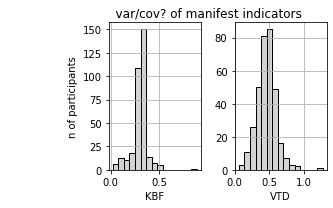

In [12]:
### mvar : variance of manifest indicators reflects the within-person variability in measurement error, and unsurprisingly, 
#it is higher for KBF, indicating that measures of  KBF  tend  to  fluctuate more 
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mvarY1','mvarY2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                            var/cov? of manifest indicators')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

# T0m_ - initial stage w.r.t later stages

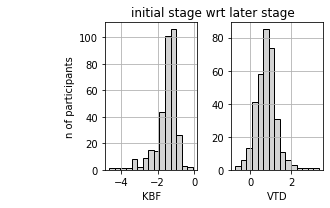

In [13]:
#T0m_eta2  is  the  initial  stage  of  the VTD latent  processe with  respect  to  later stages. Positive  values  indicate  
#that  initial  level  of  VTD  is  higher  than  at  later  stages,  i.e.  VTD  diminish  as  time  goes  by.
#DONT confuse initial stage with starting values...
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['T0m_eta1','T0m_eta2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                initial stage wrt later stage')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

# drift - change over time

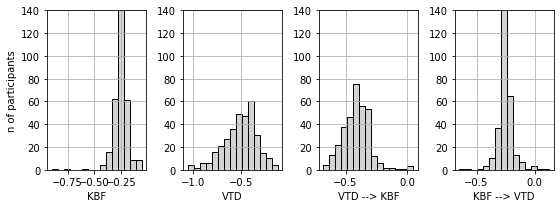

In [14]:
#distribution individual continuous time auto-effects
c = 4 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['drift_eta1','drift_eta2','drift_eta1_eta2','drift_eta2_eta1'],['KBF','VTD','VTD --> KBF','KBF --> VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
    plt.xlabel(name_plt)
    i = i+1
    plt.ylim(0,140)
plt.savefig(os.path.join(path_save,name+'distribution_individual_continuous_autoeffect.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()